# Part 1

In [8]:
from cleantext import clean
import re
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter

def clean_with_cleantext(text):
    cleaned_text = clean(text,
                         lower=True,
                         no_urls=True,
                         no_emails=True,
                         no_numbers=True,
                         no_digits=True,
                         replace_with_url="",
                         replace_with_email="",
                         replace_with_number="",
                         replace_with_digit="",
                         lang="en")
    cleaned_text = re.sub(r'[-\/]', ' ', cleaned_text)
    cleaned_text = re.sub(r'[!\+\/@#$%^&?!=\<\>_*.,€:;\[\]\{\}\'\"\´\¨\(\)\\]', '', cleaned_text)
    return cleaned_text

def tokenize(text):
    return word_tokenize(text.lower())

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def stem(tokens):
    porter = nltk.PorterStemmer()
    return [porter.stem(token) for token in tokens]

def process_text_pipeline(text):
    cleaned_text = clean_with_cleantext(text)
    tokens = tokenize(cleaned_text)
    tokens_no_stop = remove_stop_words(tokens)
    stemmed_tokens = stem(tokens_no_stop)
    return stemmed_tokens

[nltk_data] Downloading package punkt to /Users/maxmeldal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxmeldal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 3

In [8]:
from sklearn.metrics import accuracy_score

## Task 4

In [3]:
import pandas as pd


def prepare_data(df):
    # Check if 'type' column exists
    if 'type' in df.columns:
        included_types = ['political', 'fake', 'satire', 'reliable', 'conspiracy', 'bias', 'junksci', 'unreliable']
        df_filtered = df[df['type'].notna() & df['type'].isin(included_types)]
        reliable_types = ['reliable', 'political']
        df_filtered['type'] = df_filtered['type'].apply(lambda x: 1 if x in reliable_types else 0)
    else:
        # If 'type' column doesn't exist, proceed with the whole DataFrame
        df_filtered = df.copy()

    # Filtering rows where 'content' is not NA or empty after stripping whitespace
    df_filtered = df_filtered[df_filtered['content'].notna() & df_filtered['content'].str.strip().astype(bool)]
    # Filtering out rows where 'content' is numeric
    df_filtered = df_filtered[~df_filtered['content'].str.isnumeric().fillna(False)]

    return df_filtered

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import time

print('reading and splitting data...')
start_time = time.time()

path = 'cleaned.csv'
df = pd.read_csv(path)

df = prepare_data(df)

X = np.array(df['content'])
y = np.array(df['type'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

elapsed_time = time.time() - start_time
print(f"finished reading and splitting data in: {elapsed_time:.3f} seconds")

reading and splitting data...


/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_62230/278137831.py:9: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_62230/3462548003.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['type'] = df_filtered['type'].apply(lambda x: 1 if x in reliable_types else 0)


finished reading and splitting data in: 19.464 seconds


# Part 2

## Task 0

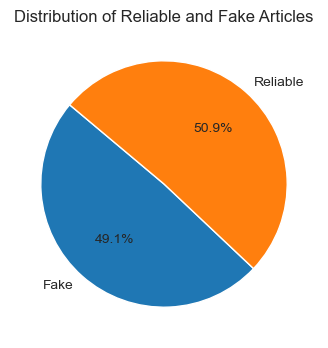

In [64]:
import matplotlib.pyplot as plt


def plot_distribution(counts):
    # Plotting
    labels = ['Fake', 'Reliable']
    plt.figure(figsize=(6, 4))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Reliable and Fake Articles')
    plt.show()


_, counts = np.unique(y, return_counts=True)
plot_distribution(counts)

## Task 1

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import re
from joblib import dump, load


def random_guessing_performance(X_train, y_train, X_val, y_val):
    uniform_classifier = DummyClassifier(strategy='uniform', random_state=0)
    uniform_classifier.fit(X_train, y_train)
    uniform_y_pred = uniform_classifier.predict(X_val)
    uniform_accuracy = accuracy_score(y_val, uniform_y_pred)
    print(f"Accuracy of Uniform Random classifier: {uniform_accuracy:.4f}")
    return uniform_accuracy


def guessing_most_frequent_performance(X_train, y_train, X_val, y_val):
    most_frequent_classifier = DummyClassifier(strategy='most_frequent', random_state=0)
    most_frequent_classifier.fit(X_train, y_train)
    most_frequent_y_pred = most_frequent_classifier.predict(X_val)
    most_frequent_accuracy = accuracy_score(y_val, most_frequent_y_pred)
    print(f"Accuracy of Most Frequent classifier: {most_frequent_accuracy:.4f}")
    return most_frequent_accuracy


def logistic_regression_performance(X_train, y_train, X_val, y_val, saveName=None, simple=False):
    print('fitting logistic regression...')
    start_time = time.time()

    parameters = {
        'C': [0.1, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs'],
        'tol': [1e-4, 1e-2],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 1000],
    }
    if simple:
        logistic_regression_classifier = LogisticRegression(solver="liblinear")
    else:
        logistic_regression_classifier = GridSearchCV(LogisticRegression(), parameters, cv=3, scoring='accuracy',
                                                      verbose=1, n_jobs=-1)

    logistic_regression_classifier.fit(X_train, y_train)
    logistic_regression_y_pred = logistic_regression_classifier.predict(X_val)
    logistic_regression_accuracy = accuracy_score(y_val, logistic_regression_y_pred)
    print(f"Accuracy of Logistic Regression classifier: {logistic_regression_accuracy:.4f}")

    elapsed_time = time.time() - start_time
    print(f"finished fitting logistic regression in: {elapsed_time:.3f} seconds")
    if saveName:
        dump(logistic_regression_classifier, saveName)
    return logistic_regression_accuracy


def display_model_comparisons(model_names, accuracies, title, f1_scores=None):
    # Check if f1_scores are provided
    if f1_scores is not None:
        # Set up the matplotlib figure and axes for two plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))  # Adjust for two plots side by side
        # Plot F1 scores in the second plot
        # Combine the model names and F1 scores, sort them by F1 scores in descending order
        combined_f1 = sorted(zip(model_names, f1_scores), key=lambda x: x[1], reverse=True)
        sorted_model_names_f1, sorted_f1_scores = zip(*combined_f1)
        ax2.bar(sorted_model_names_f1, sorted_f1_scores, color='lightgreen')
        ax2.set_title(title)
        ax2.set_ylabel('F1 Score')
        ax2.set_ylim(0, 1)  # Assuming F1 score values are between 0 and 1
        ax2.set_xticks(range(len(sorted_model_names_f1)))
        ax2.set_xticklabels(sorted_model_names_f1, rotation=45, ha="right")
        for i, v in enumerate(sorted_f1_scores):
            ax2.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
    else:
        # Set up the matplotlib figure and axes for a single plot if no f1_scores are provided
        fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Plotting sorted accuracy scores
    # Combine the model names and accuracies, sort them by accuracies in descending order
    combined_acc = sorted(zip(model_names, accuracies), key=lambda x: x[1], reverse=True)
    sorted_model_names_acc, sorted_accuracies = zip(*combined_acc)
    ax1.bar(sorted_model_names_acc, sorted_accuracies, color='skyblue')
    ax1.set_title(title)
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)  # Assuming accuracy values are between 0 and 1
    ax1.set_xticks(range(len(sorted_model_names_acc)))
    ax1.set_xticklabels(sorted_model_names_acc, rotation=45, ha="right")
    for i, v in enumerate(sorted_accuracies):
        ax1.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom')
    
    # Improve layout and show plot
    plt.tight_layout()
    plt.show()


def extract_number_of_tokens(content):
    if isinstance(content, str):
        tokens = content.split()
        return len(tokens)
    else:
        return 0


def extract_content_length(content):
    if isinstance(content, str):
        return len(content)
    else:
        return 0


def extract_avg_token_length(content):
    if isinstance(content, str):
        tokens = content.split(' ')
        token_lengths = sum([len(token) for token in tokens])
        return token_lengths / len(tokens)
    else:
        return 0


def count_truth_variations(text):
    if isinstance(text, str):
        pattern = re.compile(r'\btr(?:ue|uth|uly|uthful|uthfulness)\b', re.IGNORECASE)
        true_count = len(pattern.findall(text))
        return true_count
    else:
        return 0


def count_term_occurrences(text):
    if isinstance(text, str):
        pattern = re.compile(r'\bsaid|mr|new|iran|iranian|year|york|rec|main|newslett\b', re.IGNORECASE)
        true_count = len(pattern.findall(text))
        return true_count
    else:
        return 0

In [66]:
def compare_baseline_models_on_content_features(X_train, y_train, X_val, y_val, title='Model Accuracies'):
    X_train_content_length = np.vectorize(extract_content_length)(X_train)
    X_val_content_length = np.vectorize(extract_content_length)(X_val)

    X_train_token_length = np.vectorize(extract_avg_token_length)(X_train)
    X_val_token_length = np.vectorize(extract_avg_token_length)(X_val)

    X_train_number_of_tokens = np.vectorize(extract_number_of_tokens)(X_train)
    X_val_number_of_tokens = np.vectorize(extract_number_of_tokens)(X_val)

    X_train_truth_counts = np.vectorize(count_truth_variations)(X_train)
    X_val_truth_counts = np.vectorize(count_truth_variations)(X_val)

    X_train_term_counts = np.vectorize(count_term_occurrences)(X_train)
    X_val_term_counts = np.vectorize(count_term_occurrences)(X_val)

    models = [
        'Random Guessing',
        'Guessing Most Frequent',
        'Logistic Regression - Content Length',
        'Logistic Regression - Token Length',
        'Logistic Regression - Number of Tokens',
        'Logistic Regression - Number of Truth Variations',
        'Logistic Regression - Term Counts'
    ]

    accuracies = [
        random_guessing_performance(X_train, y_train, X_val, y_val),
        guessing_most_frequent_performance(X_train, y_train, X_val, y_val),
        logistic_regression_performance(X_train_content_length, y_train, X_val_content_length, y_val),
        logistic_regression_performance(X_train_token_length, y_train, X_val_token_length, y_val),
        logistic_regression_performance(X_train_number_of_tokens, y_train, X_val_number_of_tokens, y_val),
        logistic_regression_performance(X_train_truth_counts, y_train, X_val_truth_counts, y_val),
        logistic_regression_performance(X_train_term_counts, y_train, X_val_term_counts, y_val,
                                        saveName="lr_term_counts.joblib")
    ]

    display_model_comparisons(models, accuracies, title)

Accuracy of Uniform Random classifier: 0.5007
Accuracy of Most Frequent classifier: 0.5106
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5945
finished fitting logistic regression in: 6.527 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5154
finished fitting logistic regression in: 3.446 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5906
finished fitting logistic regression in: 5.492 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5154
finished fitting logistic regression in: 3.073 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regr

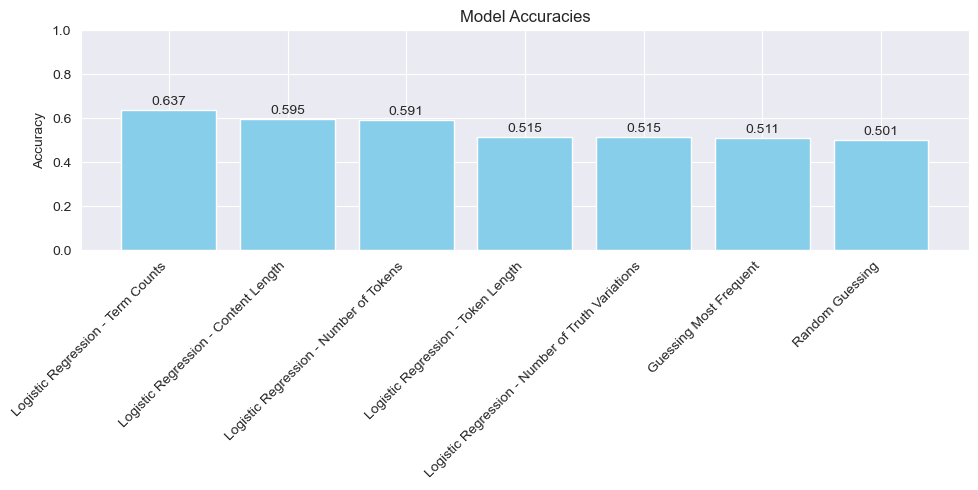

In [67]:
compare_baseline_models_on_content_features(X_train.reshape(-1, 1), y_train, X_val.reshape(-1, 1), y_val)

## Task 2

In [55]:
X_title = np.array(df['title'])

X_train_title, X_temp_title, y_train_title, y_temp_title = train_test_split(X_title, y, test_size=0.2, random_state=27)
X_val_title, _, y_val_title,_ = train_test_split(X_temp_title, y_temp_title, test_size=0.5, random_state=27)

def get_title_length(X):
    features = []
    for t in X:
        if isinstance(t, str):
            features.append(len(t))
        else:
            features.append(0)
    return np.array(features)

X_train_title_length = get_title_length(X_train_title)
X_val_title_length = get_title_length(X_val_title)

X_val_title_length_accuracy = logistic_regression_performance(X_train_title_length.reshape(-1, 1), y_train_title, X_val_title_length.reshape(-1, 1), y_val_title)

fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5625
finished fitting logistic regression in: 6.850 seconds


## Task 3

In [5]:
print('reading and splitting data...')
start_time = time.time()

path = 'bbc_cleaned.csv'
df_scraped = pd.read_csv(path)
df_scraped = prepare_data(df_scraped)

X = np.concatenate((X, np.array(df_scraped['content'])))
y = np.concatenate((y, np.ones(len(df_scraped['content']))))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)

elapsed_time = time.time() - start_time
print(f"finished reading and splitting data in: {elapsed_time:.3f} seconds")

reading and splitting data...
finished reading and splitting data in: 0.186 seconds


Accuracy of Uniform Random classifier: 0.4982
Accuracy of Most Frequent classifier: 0.5105
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5969
finished fitting logistic regression in: 5.730 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5148
finished fitting logistic regression in: 3.349 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5967
finished fitting logistic regression in: 5.268 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regression classifier: 0.5173
finished fitting logistic regression in: 3.260 seconds
fitting logistic regression...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Accuracy of Logistic Regr

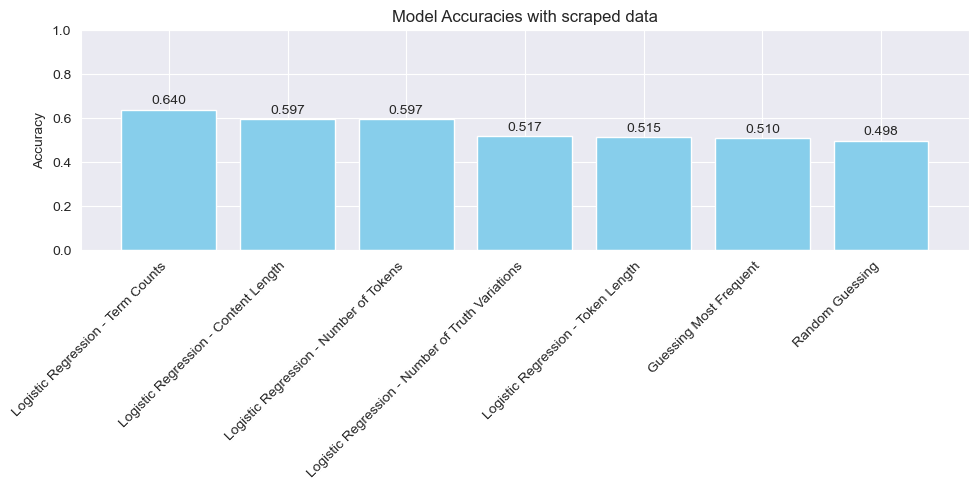

In [138]:
compare_baseline_models_on_content_features(X_train.reshape(-1, 1), y_train, X_val.reshape(-1, 1), y_val,
                                            title="Model Accuracies with scraped data")

# Part 3: Advanced models

## Prepare data

### Convert training and validation set to vectors representing how many times specific terms occur

In [18]:
import regex as re

def normalize_vectors(vectors):
    """
    Normalize each vector in the list of vectors.
    Each vector is divided by its L2 norm. The vectors are assumed to be 11-dimensional,
    with the last element being the length of the text.
    """
    normalized = np.array(vectors, dtype=float)  # Ensure the array is in float for division
    norms = np.linalg.norm(normalized, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Prevent division by zero
    return normalized / norms


def count_term_occurrences_as_vectors(X):
    X_features = []
    words = ['said', 'mr', 'new', 'iran', 'iranian', 'year', 'york', 'rec', 'main', 'newslett']
    for text in X:
        if isinstance(text, str):
            counts = [0] * len(words)
            for i, word in enumerate(words):
                pattern = re.compile(r'\b' + word + r'\b', re.IGNORECASE)
                counts[i] = len(pattern.findall(text))
            counts.append(len(text))  # Append the length of the text as the 11th dimension
            X_features.append(counts)
        else:
            X_features.append([0] * (len(words) + 1))  # Include a slot for text length
    return np.array(X_features)


# Assuming X_train and X_val are defined and are arrays of text data
X_train_count_terms = count_term_occurrences_as_vectors(X_train)
X_val_count_terms = count_term_occurrences_as_vectors(X_val)

# Normalize the vectors
X_train_count_terms_normalized = normalize_vectors(X_train_count_terms)
X_val_count_terms_normalized = normalize_vectors(X_val_count_terms)

### Convert training and validation sets to TF-IDF vectors using respectively unigrams and bigrams

#### Fit and save TF-IDF vectorizers

In [ ]:
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_unigram_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_unigram_vectorizer.fit(X_train)

dump(tfidf_unigram_vectorizer, 'vectorizer_1_1.joblib')

tfidf_bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2))
tfidf_bigram_vectorizer.fit(X_train)

dump(tfidf_bigram_vectorizer, 'vectorizer_2_2.joblib')

#### Load vectorizers and convert training and validation sets to TF-IDF vectors

In [8]:
from joblib import load
from scipy.sparse import hstack

print('loading vectorizers')
tfidf_unigram_vectorizer = load('vectorizer_1_1.joblib')
tfidf_bigram_vectorizer = load('vectorizer_2_2.joblib')

print('transforming unigrams')
X_train_tfidf_unigram = tfidf_unigram_vectorizer.transform(X_train)
X_val_tfidf_unigram = tfidf_unigram_vectorizer.transform(X_val)

print('transforming bigrams')
X_train_tfidf_bigram = tfidf_bigram_vectorizer.transform(X_train)
X_val_tfidf_bigram = tfidf_bigram_vectorizer.transform(X_val)

print('combining training data vectors')
X_train_tfidf_combined = hstack([X_train_tfidf_unigram, X_train_tfidf_bigram])
print('combining validation data vectors')
X_val_tfidf_combined = hstack([X_val_tfidf_unigram, X_val_tfidf_bigram])

loading vectorizers
transforming unigrams
transforming bigrams
combining training data vectors
combining validation data vectors


### Convert training and validation sets to word embedding vectors, using respectively a simple averaging technique and averaging using TF-IDF weights

In [9]:
from tqdm import tqdm

def load_word_embeddings(embeddings_path):
    # Placeholder function to load word embeddings
    # Replace with actual loading code depending on the format of your embeddings
    embeddings = {}
    with open(embeddings_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


print('loading word embeddings')
word_embeddings = load_word_embeddings('glove.6B.100d.txt')  # Load embeddings


def article_to_embedding(X, tfidf_vectorizer=None):
    embeddings_dim = len(next(iter(word_embeddings.values())))
    X_embeddings = np.zeros((len(X), embeddings_dim))

    if tfidf_vectorizer:
        tfidf_matrix = tfidf_vectorizer.transform(X)
        feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

        for i in tqdm(range(tfidf_matrix.shape[0]), desc="Embedding articles, TF-IDF averaging"):
            # Directly access non-zero elements for efficiency
            row, col = tfidf_matrix[i].nonzero()
            scores = tfidf_matrix[i].data
            weighted_embeddings = np.zeros(embeddings_dim)
            total_weight = 0

            for j, score in zip(col, scores):
                word = feature_names[j]
                if word in word_embeddings:
                    weighted_embeddings += word_embeddings[word] * score
                    total_weight += score

            if total_weight > 0:
                X_embeddings[i] = weighted_embeddings / total_weight
    else:
        for i in tqdm(range(len(X)), desc='Embedding articles, simple averaging'):
            words = X[i].split()
            valid_embeddings = [word_embeddings[word] for word in words if word in word_embeddings]

            if valid_embeddings:
                X_embeddings[i] = np.mean(valid_embeddings, axis=0)

    return X_embeddings

X_train_embedded_simple = article_to_embedding(X_train)
X_val_embedded_simple = article_to_embedding(X_val)

X_train_embedded_tfidf = article_to_embedding(X_train, tfidf_unigram_vectorizer)
X_val_embedded_tfidf = article_to_embedding(X_val, tfidf_unigram_vectorizer)

loading word embeddings


Embedding articles, TF-IDF averaging: 100%|██████████| 81579/81579 [00:20<00:00, 3968.05it/s]


## Naive Bayes

### Training

#### Term occurrence

In [19]:
from sklearn.naive_bayes import MultinomialNB

# Train on term occurrences vectors
nb_term_occurrences = MultinomialNB()
nb_term_occurrences.fit(X_train_count_terms_normalized, y_train)

# Validation set accuracy
nb_term_occurrences_y_val_pred = nb_term_occurrences.predict(X_val_count_terms_normalized)
nb_term_occurrences_accuracy = accuracy_score(y_val, nb_term_occurrences_y_val_pred)
print(f'Validation Set Accuracy: {nb_term_occurrences_accuracy}')

Validation Set Accuracy: 0.5104745093712842


#### TF-IDF Unigram

In [20]:
# Train on TF-IDF unigram vectors
nb_tfidf_unigram = MultinomialNB()
nb_tfidf_unigram.fit(X_train_tfidf_unigram, y_train)

# Validation set accuracy
nb_tfidf_unigram_y_val_pred = nb_tfidf_unigram.predict(X_val_tfidf_unigram)
nb_tfidf_unigram_accuracy = accuracy_score(y_val, nb_tfidf_unigram_y_val_pred)
print(f'Validation Set Accuracy: {nb_tfidf_unigram_accuracy}')

Validation Set Accuracy: 0.8140452812611089


#### TF-IDF Bigram

In [21]:
# Train on TF-IDF bigram vectors
nb_tfidf_bigram = MultinomialNB()
nb_tfidf_bigram.fit(X_train_tfidf_bigram, y_train)

# Validation set accuracy
nb_tfidf_bigram_y_val_pred = nb_tfidf_bigram.predict(X_val_tfidf_bigram)
nb_tfidf_bigram_accuracy = accuracy_score(y_val, nb_tfidf_bigram_y_val_pred)
print(f'Validation Set Accuracy: {nb_tfidf_bigram_accuracy}')

Validation Set Accuracy: 0.8487968717439537


#### TF-IDF Combined

In [22]:
# Train on TF-IDF combined vectors
nb_tfidf_combined = MultinomialNB()
nb_tfidf_combined.fit(X_train_tfidf_combined, y_train)

# Validation set accuracy
nb_tfidf_combined_y_val_pred = nb_tfidf_combined.predict(X_val_tfidf_combined)
nb_tfidf_combined_accuracy = accuracy_score(y_val, nb_tfidf_combined_y_val_pred)
print(f'Validation Set Accuracy: {nb_tfidf_combined_accuracy}')

Validation Set Accuracy: 0.8159085058654801


#### Word embeddings
Since the Naive Bayes model is based on counting frequencies, it does not accept negative feature values. Word embeddings will therefore not work for this type of model.

### Compare Naive Bayes model performances

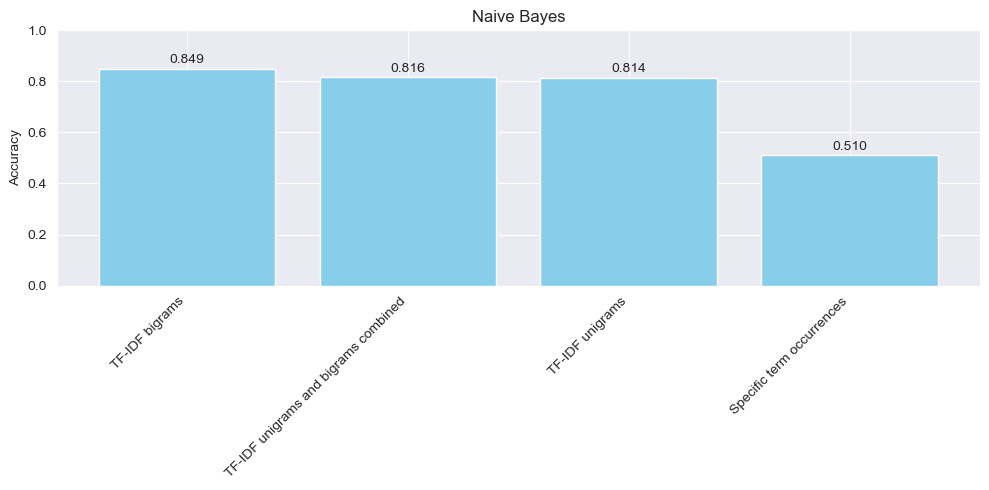

In [23]:
# Compare Naive Bayes performances
models = [
    'Specific term occurrences',
    'TF-IDF unigrams',
    'TF-IDF bigrams',
    'TF-IDF unigrams and bigrams combined'
]

accuracies = [
    nb_term_occurrences_accuracy,
    nb_tfidf_unigram_accuracy,
    nb_tfidf_bigram_accuracy,
    nb_tfidf_combined_accuracy
]

display_model_comparisons(models, accuracies, 'Naive Bayes')

## Logistic Regression
### Training

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {
    'C': [0.1, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
    'tol': [1e-4, 1e-2],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 1000],
}

#### Term Occurrences

In [25]:
# Train on term occurrences vectors
lr_term_occurrences = LogisticRegression()
lr_term_occurrences.fit(X_train_count_terms_normalized, y_train)

# Validation set accuracy
lr_term_occurrences_y_val_pred = lr_term_occurrences.predict(X_val_count_terms_normalized)
lr_term_occurrences_accuracy = accuracy_score(y_val, lr_term_occurrences_y_val_pred)
print(f'Validation Set Accuracy: {lr_term_occurrences_accuracy}')

Validation Set Accuracy: 0.6696208583091237


#### TF-IDF Unigram

In [26]:
# Train on TF-IDF unigram vectors
lr_tfidf_unigram = LogisticRegression()
lr_tfidf_unigram.fit(X_train_tfidf_unigram, y_train)

# Validation set accuracy
lr_tfidf_unigram_y_val_pred = lr_tfidf_unigram.predict(X_val_tfidf_unigram)
lr_tfidf_unigram_accuracy = accuracy_score(y_val, lr_tfidf_unigram_y_val_pred)
print(f'Validation Set Accuracy: {lr_tfidf_unigram_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Set Accuracy: 0.8833278172078599


#### TF-IDF Bigram

In [27]:
# Train on TF-IDF bigram vectors
lr_tfidf_bigram = LogisticRegression()
lr_tfidf_bigram.fit(X_train_tfidf_bigram, y_train)

# Validation set accuracy
lr_tfidf_bigram_y_val_pred = lr_tfidf_bigram.predict(X_val_tfidf_bigram)
lr_tfidf_bigram_accuracy = accuracy_score(y_val, lr_tfidf_bigram_y_val_pred)
print(f'Validation Set Accuracy: {lr_tfidf_bigram_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Set Accuracy: 0.9010529670626019


#### TF-IDF Combined

In [28]:
# Train on TF-IDF combined vectors
lr_tfidf_combined = LogisticRegression()
lr_tfidf_combined.fit(X_train_tfidf_combined, y_train)

# Validation set accuracy
lr_tfidf_combined_y_val_pred = lr_tfidf_combined.predict(X_val_tfidf_combined)
lr_tfidf_combined_accuracy = accuracy_score(y_val, lr_tfidf_combined_y_val_pred)
print(f'Validation Set Accuracy: {lr_tfidf_combined_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Set Accuracy: 0.9088000588386718


#### Simple word embedding

In [29]:
# Train on embedded simple vectors
lr_embedded_simple = LogisticRegression()
lr_embedded_simple.fit(X_train_embedded_simple, y_train)

# Validation set accuracy
lr_embedded_simple_y_val_pred = lr_embedded_simple.predict(X_val_embedded_simple)
lr_embedded_simple_accuracy = accuracy_score(y_val, lr_embedded_simple_y_val_pred)
print(f'Validation Set Accuracy: {lr_embedded_simple_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Set Accuracy: 0.7402150063128992


#### TF-IDF word embedding

In [30]:
# Train on embedded tfidf vectors
lr_embedded_tfidf = LogisticRegression()
lr_embedded_tfidf.fit(X_train_embedded_tfidf, y_train)

# Validation set accuracy
lr_embedded_tfidf_y_val_pred = lr_embedded_tfidf.predict(X_val_embedded_tfidf)
lr_embedded_tfidf_accuracy = accuracy_score(y_val, lr_embedded_tfidf_y_val_pred)
print(f'Validation Set Accuracy: {lr_embedded_tfidf_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Set Accuracy: 0.7307640446683583


### Compare Logistic Regression performances

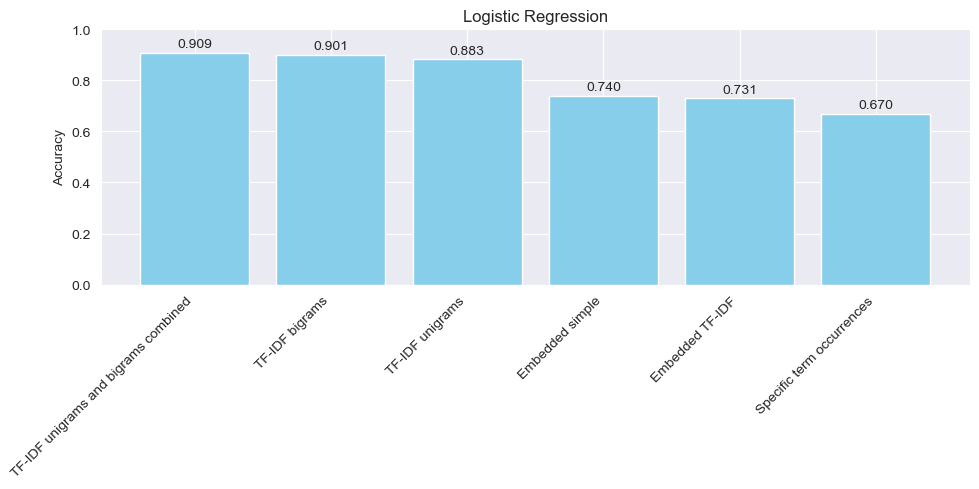

In [31]:
# Compare Logistic Regression performances
models = [
    'Specific term occurrences',
    'TF-IDF unigrams',
    'TF-IDF bigrams',
    'TF-IDF unigrams and bigrams combined',
    'Embedded simple',
    'Embedded TF-IDF'
]

accuracies = [
    lr_term_occurrences_accuracy,
    lr_tfidf_unigram_accuracy,
    lr_tfidf_bigram_accuracy,
    lr_tfidf_combined_accuracy,
    lr_embedded_simple_accuracy,
    lr_embedded_tfidf_accuracy
]

display_model_comparisons(models, accuracies, 'Logistic Regression')

## Support Vector Machine
### Training
#### Term Occurrences

In [32]:
def get_scv():
    return SVC(
    kernel='linear',  # Use a linear kernel which is generally faster than 'rbf' for large datasets
    C=0.1,            # Decrease C to potentially reduce training time, with a possible increase in bias
    tol=0.01,         # Increase the tolerance for the stopping criterion to converge faster
    cache_size=500,   # Increase cache size to reduce the number of cache misses, if memory allows
    shrinking=False,  # Disable shrinking heuristic; might reduce time in some cases
    max_iter=1000     # Limit the number of iterations to ensure the solver stops earlier
)

In [33]:
from sklearn.svm import SVC

# Train on term occurrences vectors
svm_term_occurrences = get_scv()
svm_term_occurrences.fit(X_train_count_terms_normalized, y_train)

# Validation set accuracy
svm_term_occurrences_y_val_pred = svm_term_occurrences.predict(X_val_count_terms_normalized)
svm_term_occurrences_accuracy = accuracy_score(y_val, svm_term_occurrences_y_val_pred)
print(f'Validation Set Accuracy: {svm_term_occurrences_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Set Accuracy: 0.5105970899373613


#### Embedded simple

In [34]:
# Train on embedded simple vectors
svm_embedded_simple = get_scv()
svm_embedded_simple.fit(X_train_embedded_simple, y_train)

# Validation set accuracy
svm_embedded_simple_y_val_pred = svm_embedded_simple.predict(X_val_embedded_simple)
svm_embedded_simple_accuracy = accuracy_score(y_val, svm_embedded_simple_y_val_pred)
print(f'Validation Set Accuracy: {svm_embedded_simple_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Set Accuracy: 0.5449441645521519


#### Embedded TF-IDF

In [35]:
# Train on embedded tfidf vectors
svm_embedded_tfidf = get_scv()
svm_embedded_tfidf.fit(X_train_embedded_tfidf, y_train)

# Validation set accuracy
svm_embedded_tfidf_y_val_pred = svm_embedded_tfidf.predict(X_val_embedded_tfidf)
svm_embedded_tfidf_accuracy = accuracy_score(y_val, svm_embedded_tfidf_y_val_pred)
print(f'Validation Set Accuracy: {svm_embedded_tfidf_accuracy}')

/Users/maxmeldal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Set Accuracy: 0.5316564311893992


#### TF-IDF
Too many dimensions to do TF-IDF vectors for SVM

### Compare Support Vector Machine performances

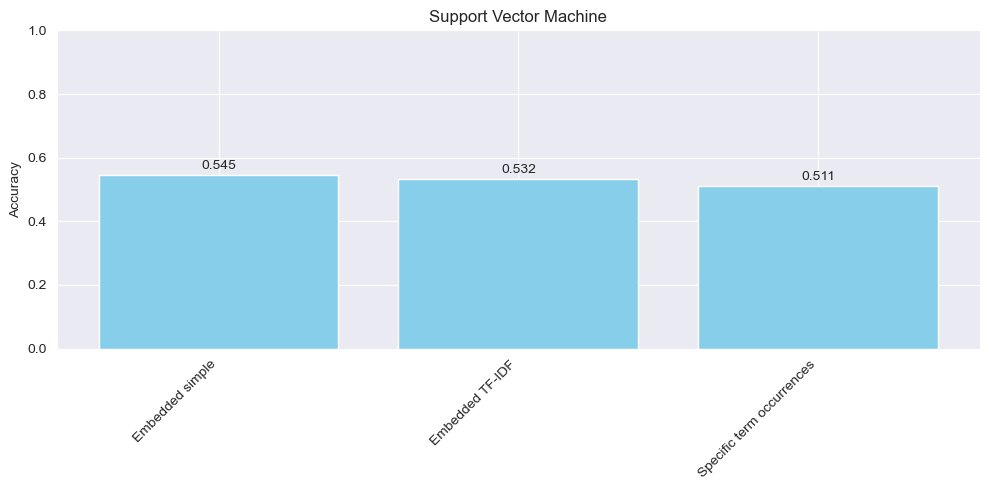

In [36]:
# Compare Support Vector Machine performances
models = [
    'Specific term occurrences',
    'Embedded simple',
    'Embedded TF-IDF'
]

accuracies = [
    svm_term_occurrences_accuracy,
    svm_embedded_simple_accuracy,
    svm_embedded_tfidf_accuracy
]

display_model_comparisons(models, accuracies, 'Support Vector Machine')

## Neural Net
### Training
#### Term Occurences

In [37]:
from tensorflow.keras import layers, regularizers, optimizers, callbacks, models as md

def get_neural_net(input_shape):
    # Model architecture
    model = md.Sequential([
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),  # Increased layer size
        layers.LeakyReLU(negative_slope=0.01),  # Changed activation function
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),  # Added another layer
        layers.LeakyReLU(negative_slope=0.01),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
        layers.LeakyReLU(negative_slope=0.01),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])
    return model

# Callbacks for early stopping and learning rate reduction
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [38]:
# Train on term occurrences vectors
nn_term_occurrences = get_neural_net(X_train_count_terms_normalized.shape[1])
nn_term_occurrences.fit(X_train_count_terms_normalized, y_train,
                    validation_data=(X_val_count_terms_normalized, y_val),
                    epochs=100,  # Increased number of epochs with early stopping will regulate it
                    batch_size=64,  # Consider experimenting with batch size
                    callbacks=[early_stopping])

# Validation set accuracy
_, nn_term_occurrences_accuracy,_,_ = nn_term_occurrences.evaluate(X_val_count_terms_normalized, y_val)
print(f'Validation Set Accuracy: {nn_term_occurrences_accuracy}')

Epoch 1/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - Precision: 0.7950 - Recall: 0.5207 - accuracy: 0.6854 - loss: 0.6283 - val_Precision: 0.3611 - val_Recall: 3.1217e-04 - val_accuracy: 0.4894 - val_loss: 4.4105
Epoch 2/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - Precision: 0.8074 - Recall: 0.5306 - accuracy: 0.6943 - loss: 0.5743 - val_Precision: 0.5105 - val_Recall: 1.0000 - val_accuracy: 0.5105 - val_loss: 1.1650
Epoch 3/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - Precision: 0.8098 - Recall: 0.5307 - accuracy: 0.6953 - loss: 0.5696 - val_Precision: 0.5714 - val_Recall: 9.6052e-05 - val_accuracy: 0.4895 - val_loss: 2.4005
Epoch 4/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - Precision: 0.8161 - Recall: 0.5240 - accuracy: 0.6950 - loss: 0.5641 - val_Precision: 0.9740 - val_Recall: 0.0117 - val_accuracy: 0.4953 - val_loss: 0.7680
Epoch 5/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - Precision: 0.8123 - Recall: 0.5257 - accuracy: 0.6946 - loss: 0.5623

#### Embedded simple

In [39]:
# Train on embedded simple vectors
nn_embedded_simple = get_neural_net(X_train_embedded_simple.shape[1])
nn_embedded_simple.fit(X_train_embedded_simple, y_train,
                    validation_data=(X_val_embedded_simple, y_val),
                    epochs=100,  # Increased number of epochs with early stopping will regulate it
                    batch_size=64,  # Consider experimenting with batch size
                    callbacks=[early_stopping])

# Validation set accuracy
_, nn_embedded_simple_accuracy, _,_ = nn_embedded_simple.evaluate(X_val_embedded_simple, y_val)
print(f'Validation Set Accuracy: {nn_embedded_simple_accuracy}')

Epoch 1/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - Precision: 0.7378 - Recall: 0.7571 - accuracy: 0.7388 - loss: 0.6941 - val_Precision: 0.7873 - val_Recall: 0.7823 - val_accuracy: 0.7810 - val_loss: 0.4977
Epoch 2/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - Precision: 0.7738 - Recall: 0.7797 - accuracy: 0.7698 - loss: 0.5113 - val_Precision: 0.7574 - val_Recall: 0.8458 - val_accuracy: 0.7830 - val_loss: 0.4780
Epoch 3/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - Precision: 0.7768 - Recall: 0.7812 - accuracy: 0.7729 - loss: 0.5014 - val_Precision: 0.8085 - val_Recall: 0.7566 - val_accuracy: 0.7843 - val_loss: 0.4669
Epoch 4/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - Precision: 0.7764 - Recall: 0.7819 - accuracy: 0.7730 - loss: 0.4962 - val_Precision: 0.7939 - val_Recall: 0.7996 - val_accuracy: 0.7918 - val_loss: 0.4594
Epoch 5/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - Precision: 0.7794 - Recall: 0.7855 - accuracy: 0.7759 - loss: 0.4890 - val_P

#### Embedded TF-IDF

In [40]:
# Train on embedded tfidf vectors
nn_embedded_tfidf = get_neural_net(X_train_embedded_tfidf.shape[1])
nn_embedded_tfidf.fit(X_train_embedded_tfidf, y_train,
                    validation_data=(X_val_embedded_tfidf, y_val),
                    epochs=100,  # Increased number of epochs with early stopping will regulate it
                    batch_size=64,  # Consider experimenting with batch size
                    callbacks=[early_stopping])

# Validation set accuracy
_, nn_embedded_tfidf_accuracy,_,_ = nn_embedded_tfidf.evaluate(X_val_embedded_tfidf, y_val)
print(f'Validation Set Accuracy: {nn_embedded_tfidf_accuracy}')

Epoch 1/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - Precision: 0.7303 - Recall: 0.7641 - accuracy: 0.7346 - loss: 0.7055 - val_Precision: 0.7785 - val_Recall: 0.8009 - val_accuracy: 0.7821 - val_loss: 0.4803
Epoch 2/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - Precision: 0.7657 - Recall: 0.7834 - accuracy: 0.7659 - loss: 0.5169 - val_Precision: 0.7810 - val_Recall: 0.7984 - val_accuracy: 0.7828 - val_loss: 0.4735
Epoch 3/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - Precision: 0.7667 - Recall: 0.7841 - accuracy: 0.7670 - loss: 0.5090 - val_Precision: 0.7604 - val_Recall: 0.8358 - val_accuracy: 0.7817 - val_loss: 0.4759
Epoch 4/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - Precision: 0.7675 - Recall: 0.7876 - accuracy: 0.7687 - loss: 0.5025 - val_Precision: 0.7729 - val_Recall: 0.8174 - val_accuracy: 0.7842 - val_loss: 0.4666
Epoch 5/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - Precision: 0.7703 - Recall: 0.7838 - accuracy: 0.7697 - loss: 0.4954 - val_P

#### TF-IDF Unigram reduced

In [78]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200)

X_train_tfidf_unigram_reduced = svd.fit_transform(X_train_tfidf_unigram)
X_val_tfidf_unigram_reduced =svd.transform(X_val_tfidf_unigram)

In [16]:
# Train on TF-IDF unigram reduced vectors
nn_tfidf_unigram_reduced = get_neural_net(X_train_tfidf_unigram_reduced.shape[1])
nn_tfidf_unigram_reduced.fit(X_train_tfidf_unigram_reduced, y_train,
                    validation_data=(X_val_tfidf_unigram_reduced, y_val),
                    epochs=100,  # Increased number of epochs with early stopping will regulate it
                    batch_size=64,  # Consider experimenting with batch size
                    callbacks=[early_stopping])

# Validation set accuracy
_, nn_tfidf_unigram_reduced_accuracy,_,_ = nn_tfidf_unigram_reduced.evaluate(X_val_tfidf_unigram_reduced, y_val)
print(f'Validation Set Accuracy: {nn_tfidf_unigram_reduced_accuracy}')

Epoch 1/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - Precision: 0.8110 - Recall: 0.7938 - accuracy: 0.7995 - loss: 0.5931 - val_Precision: 0.8455 - val_Recall: 0.8391 - val_accuracy: 0.8396 - val_loss: 0.3732
Epoch 2/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - Precision: 0.8373 - Recall: 0.8245 - accuracy: 0.8278 - loss: 0.3981 - val_Precision: 0.8315 - val_Recall: 0.8610 - val_accuracy: 0.8400 - val_loss: 0.3655
Epoch 3/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - Precision: 0.8377 - Recall: 0.8273 - accuracy: 0.8294 - loss: 0.3906 - val_Precision: 0.8576 - val_Recall: 0.8323 - val_accuracy: 0.8438 - val_loss: 0.3562
Epoch 4/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - Precision: 0.8411 - Recall: 0.8279 - accuracy: 0.8320 - loss: 0.3833 - val_Precision: 0.8470 - val_Recall: 0.8496 - val_accuracy: 0.8448 - val_loss: 0.3547
Epoch 5/100
10198/10198 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - Precision: 0.8393 - Recall: 0.8305 - accuracy: 0.8322 - loss: 0.3791 - val_P

### Compare Neural Net performances

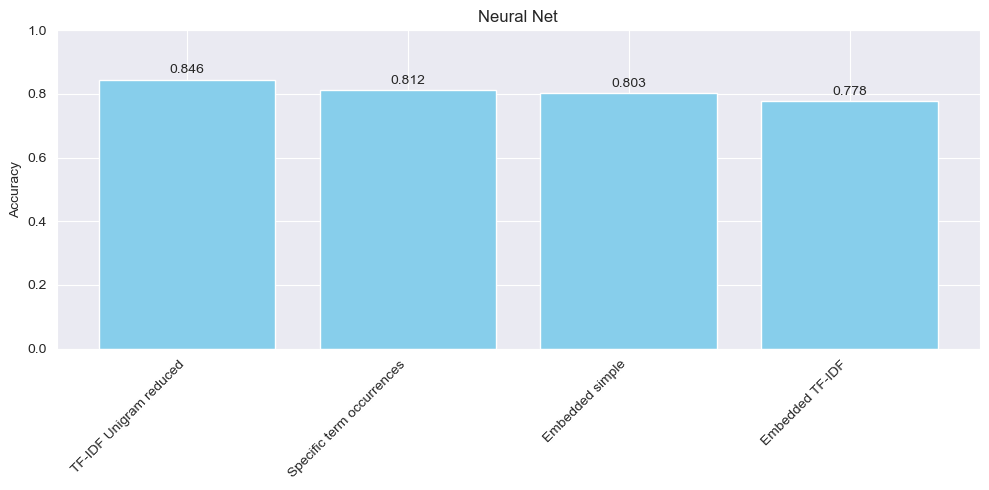

In [42]:
# Compare Neural Net performances
models = [
    'Specific term occurrences',
    'Embedded simple',
    'Embedded TF-IDF',
    'TF-IDF Unigram reduced'
]

accuracies = [
    nn_term_occurrences_accuracy,
    nn_embedded_simple_accuracy,
    nn_embedded_tfidf_accuracy,
    nn_tfidf_unigram_reduced_accuracy
]

display_model_comparisons(models, accuracies, 'Neural Net')

## Save the best performing advanced models

In [60]:
dump(lr_tfidf_combined, 'lr_tfidf_combined.joblib')
nn_tfidf_unigram_reduced.save('nn_tfidf_unigram_reduced.keras')

# Part 4: Evaluation

## Load the models

In [69]:
from tensorflow.keras.models import load_model

lr_term_counts = load('lr_term_counts.joblib')
lr_tfidf = load('lr_tfidf_combined.joblib')
nn = load_model('nn_tfidf_unigram_reduced.keras')

## Prepare test data

In [79]:
X_test_term_counts = np.vectorize(count_term_occurrences)(X_test)

print('loading vectorizers')
tfidf_unigram_vectorizer = load('vectorizer_1_1.joblib')
tfidf_bigram_vectorizer = load('vectorizer_2_2.joblib')
print('transforming unigrams')
X_test_tfidf_unigram = tfidf_unigram_vectorizer.transform(X_test)
print('transforming bigrams')
X_test_tfidf_bigram = tfidf_bigram_vectorizer.transform(X_test)
print('combining test data vectors')
X_test_tfidf_combined = hstack([X_test_tfidf_unigram, X_test_tfidf_bigram])

print('truncating unigrams')
X_test_tfidf_unigram_reduced = svd.transform(X_test_tfidf_unigram)

loading vectorizers
transforming unigrams
transforming bigrams
combining training data vectors
truncating unigrams


## Make predictions on FakeNewsCorpus test set

In [94]:
from sklearn.metrics import f1_score, confusion_matrix

lr_term_counts_y_test_pred = lr_term_counts.predict(X_test_term_counts.reshape(-1,1))
lr_term_counts_y_test_pred_accuracy = accuracy_score(y_test, lr_term_counts_y_test_pred)
lr_term_counts_y_test_pred_f1_score = f1_score(y_test, lr_term_counts_y_test_pred)
lr_term_counts_y_test_pred_cm = confusion_matrix(y_test, lr_term_counts_y_test_pred)

lr_tfidf_y_test_pred = lr_tfidf.predict(X_test_tfidf_combined)
lr_tfidf_y_test_pred_accuracy = accuracy_score(y_test, lr_tfidf_y_test_pred)
lr_tfidf_y_test_pred_f1_score = f1_score(y_test, lr_tfidf_y_test_pred)
lr_tfidf_y_test_pred_cm = confusion_matrix(y_test, lr_tfidf_y_test_pred)

def calculate_f1_score(precision, recall):
    if (precision + recall) == 0:
        return 0  # Avoid division by zero
    return 2 * (precision * recall) / (precision + recall)

nn_y_test_pred = nn.predict(X_test_tfidf_unigram_reduced)
_, nn_y_test_pred_accuracy,nn_y_test_pred_precision,nn_y_test_pred_recall = nn.evaluate(X_test_tfidf_unigram_reduced, y_test)
nn_y_test_pred_f1_score = calculate_f1_score(nn_y_test_pred_precision, nn_y_test_pred_recall)
nn_y_test_pred_cm = confusion_matrix(y_test, nn_y_test_pred.round())

2550/2550 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step - Precision: 0.8212 - Recall: 0.8104 - accuracy: 0.8132 - loss: 0.4171


##  Task 1: Compare performances

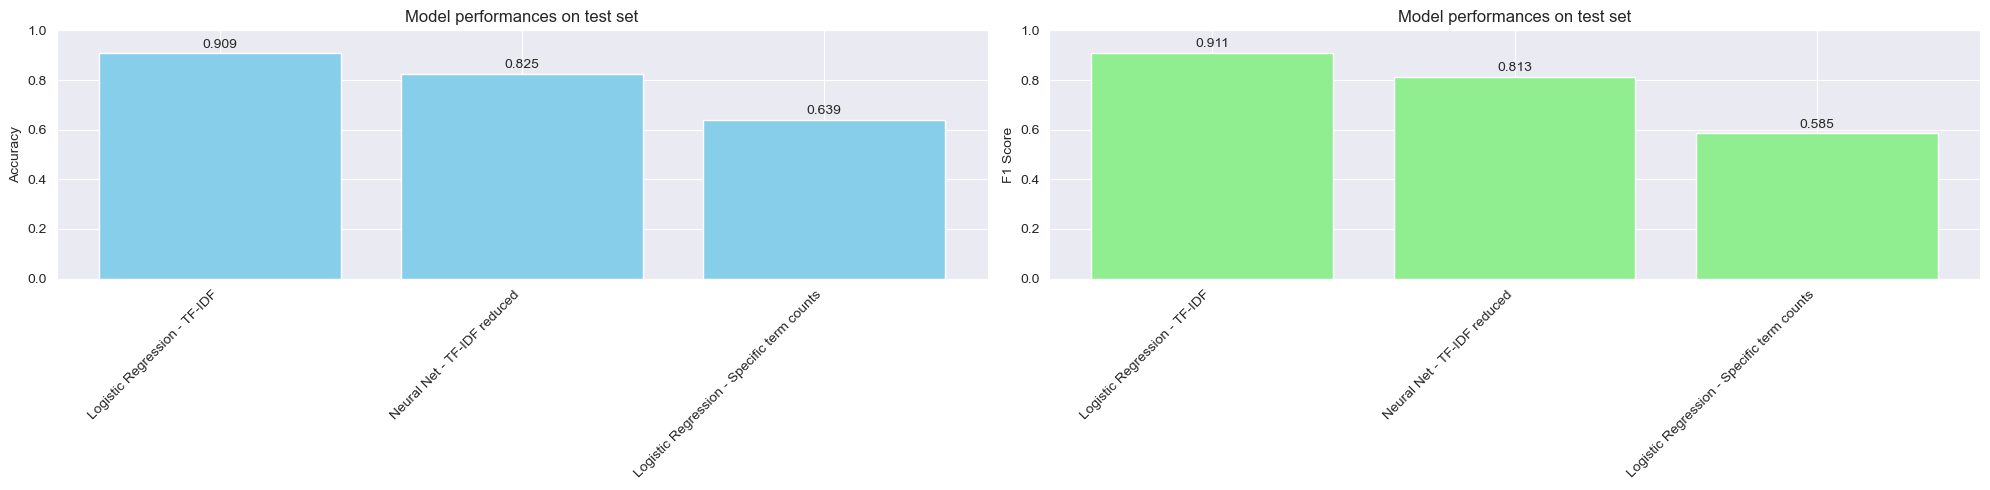

In [136]:
models = [
    'Logistic Regression - Specific term counts',
    'Logistic Regression - TF-IDF',
    'Neural Net - TF-IDF reduced'
]

accuracies = [
    lr_term_counts_y_test_pred_accuracy,
    lr_tfidf_y_test_pred_accuracy,
    nn_y_test_pred_accuracy
]

f1_scores = [
    lr_term_counts_y_test_pred_f1_score,
    lr_tfidf_y_test_pred_f1_score,
    nn_y_test_pred_f1_score
]

display_model_comparisons(models, accuracies, 'Model performances on test set', f1_scores=f1_scores)

## Plot confusion matrices

/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_52400/2175795245.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


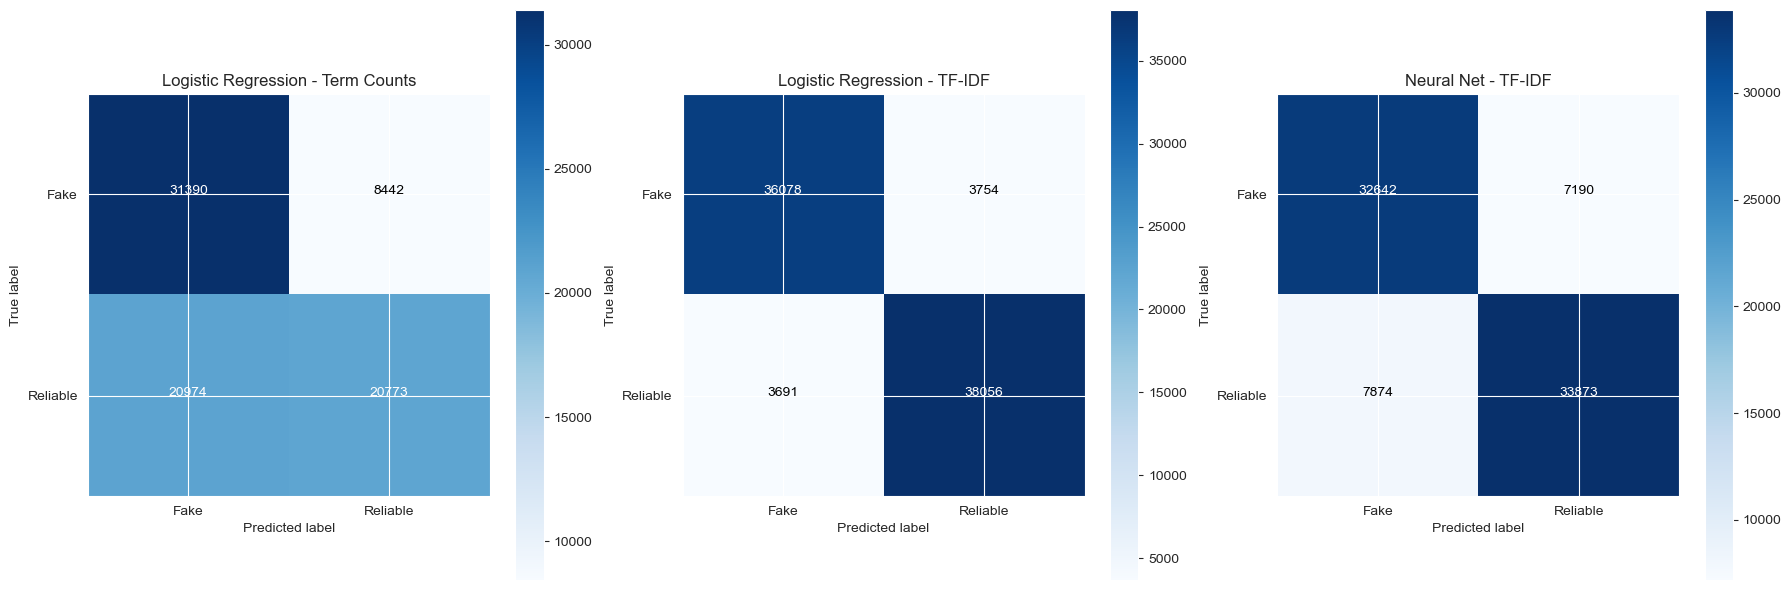

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes=['Fake', 'Reliable'],
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_confusion_matrix(lr_term_counts_y_test_pred_cm, title='Logistic Regression - Term Counts')

plt.subplot(1, 3, 2)
plot_confusion_matrix(lr_tfidf_y_test_pred_cm, title='Logistic Regression - TF-IDF')

plt.subplot(1, 3, 3)
plot_confusion_matrix(nn_y_test_pred_cm, title='Neural Net - TF-IDF')

plt.show()


## Load LIAR dataset

In [6]:
column_names = [
    'C1',
    'C2',
    'C3',
    'C4',
    'C5',
    'C6',
    'C7',
    'C8',
    'C9',
    'C10',
    'C11',
    'C12',
    'C13',
    'C14',
]

liar_train = pd.read_csv('liar_dataset/train.tsv', sep='\t', header=None, names=column_names)
liar_val = pd.read_csv('liar_dataset/valid.tsv', sep='\t')
liar_test = pd.read_csv('liar_dataset/test.tsv', sep='\t')

## Combine and preprocess liar data

In [9]:
# Combine liar_train, liar_val, and liar_test
liar_combined = pd.concat([liar_train, liar_val, liar_test])

# Drop all rows where column C2 is not 'false', 'pants-fire', or 'true'
liar_filtered = liar_combined[liar_combined['C2'].isin(['false', 'pants-fire', 'true'])]

# Save contents of column C3 to a NumPy array X_liar
X_liar_filtered = liar_filtered['C3'].to_numpy()

# Convert X_liar back to a Pandas Series
X_liar_series = pd.Series(X_liar_filtered)

# Now apply your text processing function
X_liar = X_liar_series.apply(lambda x: ' '.join(process_text_pipeline(x)) if isinstance(x, str) else x)

# Save contents of column C2 to a NumPy array y_liar
y_liar = liar_filtered['C2'].to_numpy()

# Convert all values of y_liar to 1 if equal to 'true' and 0 otherwise
y_liar = np.where(y_liar == 'true', 1, 0)

## Prepare for predictions

In [130]:
X_liar_term_counts = np.vectorize(count_term_occurrences)(X_liar)

print('transforming unigrams')
X_liar_tfidf_unigram = tfidf_unigram_vectorizer.transform(X_liar)
print('transforming bigrams')
X_liar_tfidf_bigram = tfidf_bigram_vectorizer.transform(X_liar)
print('combining liar data vectors')
X_liar_tfidf_combined = hstack([X_liar_tfidf_unigram, X_liar_tfidf_bigram])

print('truncating unigrams')
X_liar_tfidf_unigram_reduced = svd.transform(X_liar_tfidf_unigram)

transforming unigrams
transforming bigrams
combining liar data vectors
truncating unigrams


## Make predictions and calculate metrics on liar data

In [131]:
from sklearn.metrics import f1_score, confusion_matrix

lr_term_counts_y_liar_pred = lr_term_counts.predict(X_liar_term_counts.reshape(-1,1))
lr_term_counts_y_liar_pred_accuracy = accuracy_score(y_liar, lr_term_counts_y_liar_pred)
lr_term_counts_y_liar_pred_f1_score = f1_score(y_liar, lr_term_counts_y_liar_pred)
lr_term_counts_y_liar_pred_cm = confusion_matrix(y_liar, lr_term_counts_y_liar_pred)

lr_tfidf_y_liar_pred = lr_tfidf.predict(X_liar_tfidf_combined)
lr_tfidf_y_liar_pred_accuracy = accuracy_score(y_liar, lr_tfidf_y_liar_pred)
lr_tfidf_y_liar_pred_f1_score = f1_score(y_liar, lr_tfidf_y_liar_pred)
lr_tfidf_y_liar_pred_cm = confusion_matrix(y_liar, lr_tfidf_y_liar_pred)

nn_y_liar_pred = nn.predict(X_liar_tfidf_unigram_reduced)
_, nn_y_liar_pred_accuracy,nn_y_liar_pred_precision,nn_y_liar_pred_recall = nn.evaluate(X_liar_tfidf_unigram_reduced, y_liar)
nn_y_liar_pred_f1_score = calculate_f1_score(nn_y_liar_pred_precision, nn_y_liar_pred_recall)
nn_y_liar_pred_cm = confusion_matrix(y_liar, nn_y_liar_pred.round())

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - Precision: 0.4043 - Recall: 0.5222 - accuracy: 0.5374 - loss: 0.8521


## Task 2: Compare performances

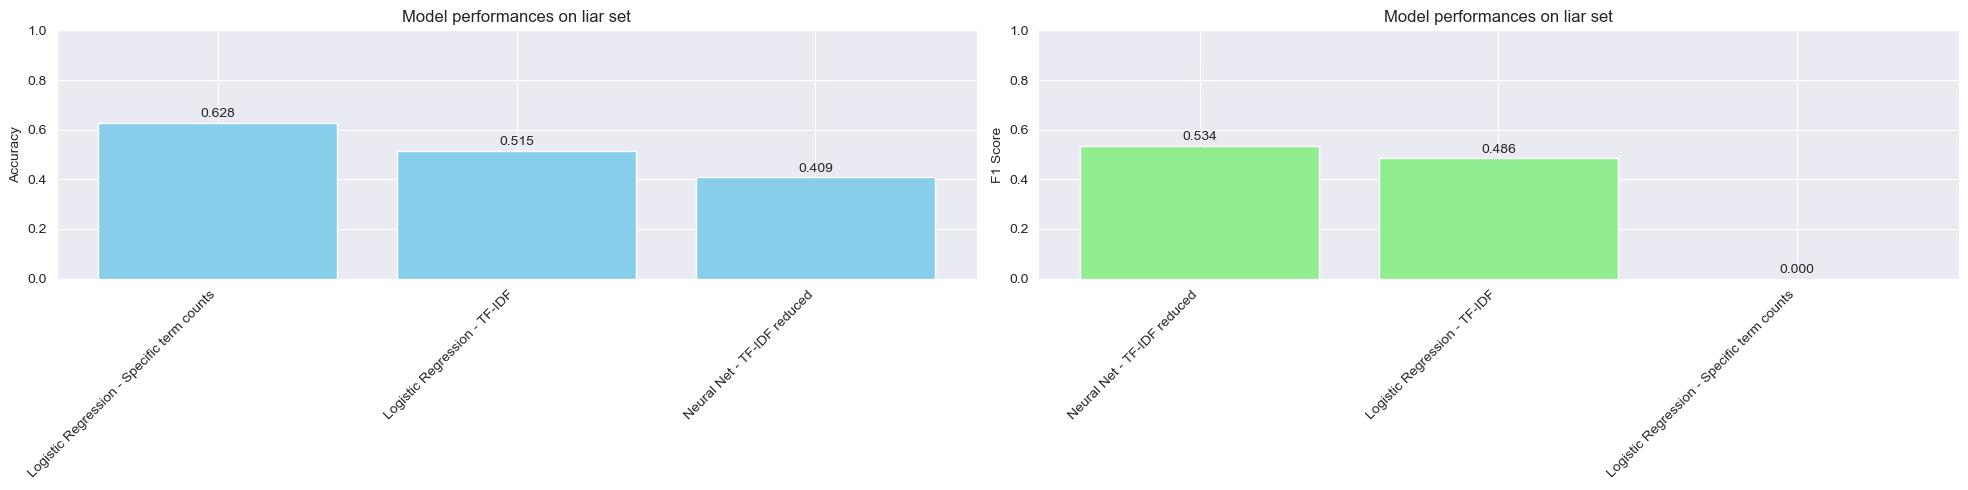

In [137]:
models = [
    'Logistic Regression - Specific term counts',
    'Logistic Regression - TF-IDF',
    'Neural Net - TF-IDF reduced'
]

accuracies = [
    lr_term_counts_y_liar_pred_accuracy,
    lr_tfidf_y_liar_pred_accuracy,
    nn_y_liar_pred_accuracy
]

f1_scores = [
    lr_term_counts_y_liar_pred_f1_score,
    lr_tfidf_y_liar_pred_f1_score,
    nn_y_liar_pred_f1_score
]

display_model_comparisons(models, accuracies, 'Model performances on liar set', f1_scores=f1_scores)

## Display confusion matrices

/var/folders/08/xjbs0s0j72s556nv4_bvymhh0000gn/T/ipykernel_52400/2175795245.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


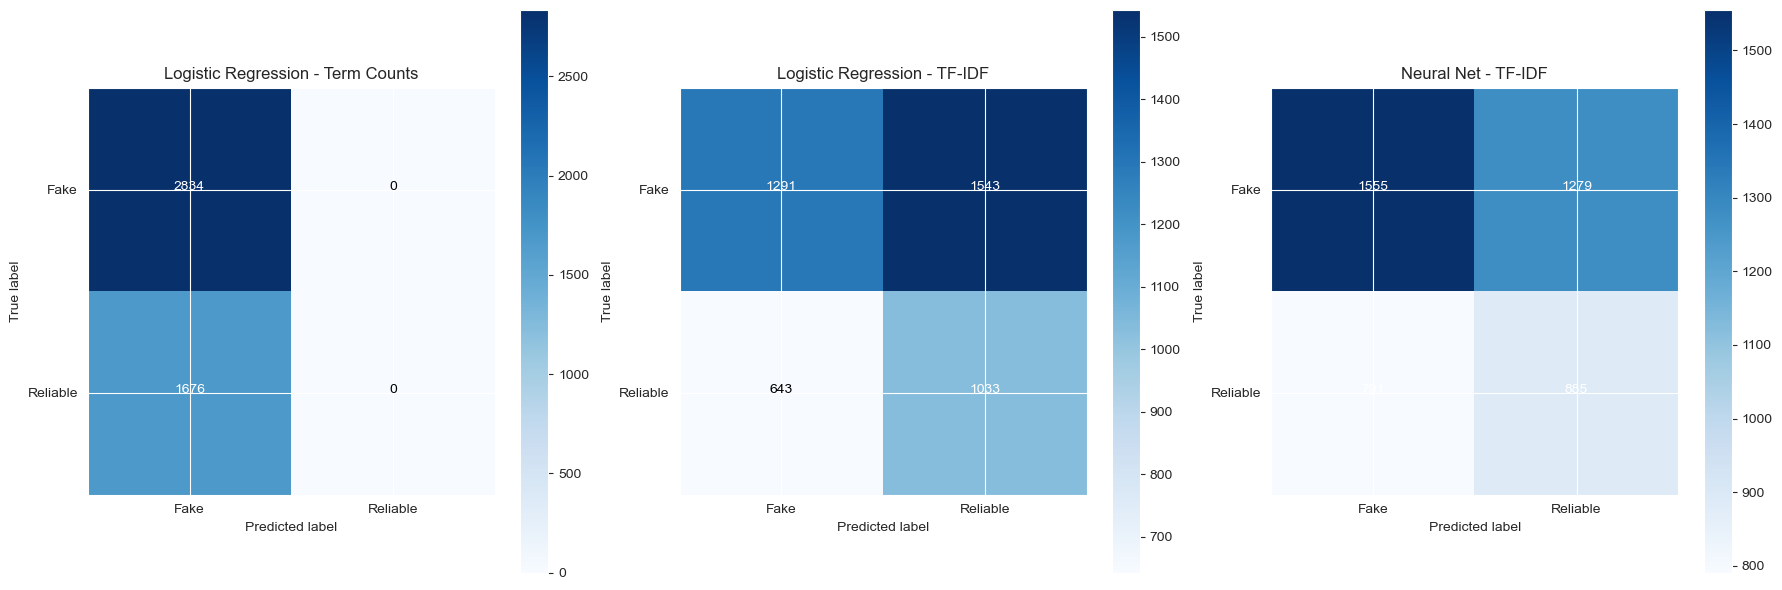

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_confusion_matrix(lr_term_counts_y_liar_pred_cm, title='Logistic Regression - Term Counts')

plt.subplot(1, 3, 2)
plot_confusion_matrix(lr_tfidf_y_liar_pred_cm, title='Logistic Regression - TF-IDF')

plt.subplot(1, 3, 3)
plot_confusion_matrix(nn_y_liar_pred_cm, title='Neural Net - TF-IDF')

plt.show()


In [10]:
fake_len_avg = df['content'].str.len().mean()
liar_len_avg = liar_combined['C3'].str.len().mean()

print(liar_len_avg)
print(fake_len_avg)

106.91875
1738.0687116927504


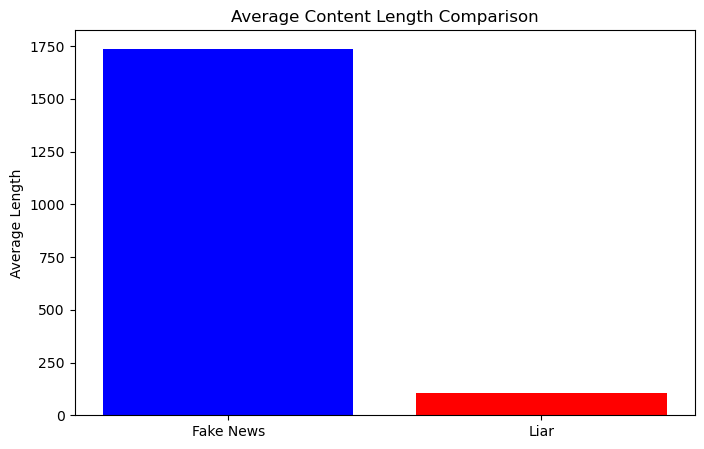

In [11]:
categories = ['Fake News', 'Liar']
values = [fake_len_avg, liar_len_avg]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'red'])
plt.title('Average Content Length Comparison')
plt.ylabel('Average Length')
plt.show()